# The Social Web Research Project

In this project, Experts of Stackoverflow Question-Answering community are found.

In [1]:
!pip install networkx
!pip install matplotlib
!pip install scipy


You should consider upgrading via the 'U:\Courses\Social Web\sw_virtual_environment\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'U:\Courses\Social Web\sw_virtual_environment\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'U:\Courses\Social Web\sw_virtual_environment\Scripts\python.exe -m pip install --upgrade pip' command.


## Sample of comments
Classic social network analysis studies a network's structure. In a social network, a person is considered a *node* or *vertex*, and a relationship between people is a *link* or *edge*. 
Many network statystics can yield insights on the underlying social structure. At the same time, their intuitive visual representation aids in developing working hypothesis explaining their dynamics.

Page rank value:  {'G': 0.12615144432268247, 'A': 0.3696105821244884, 'B': 0.18227088910435682, 'C': 0.12615144432268247, 'D': 0.12615144432268247, 'E': 0.021428571428571432, 'F': 0.048235624374535664}
sorted Page rank value:  [('A', 0.3696105821244884), ('B', 0.18227088910435682), ('G', 0.12615144432268247), ('C', 0.12615144432268247), ('D', 0.12615144432268247), ('F', 0.048235624374535664), ('E', 0.021428571428571432)]
sorted Page rank value:  [('A', 0.38173394046126047), ('B', 0.13157694877254386), ('G', 0.1295859264123554), ('C', 0.1295859264123554), ('D', 0.1295859264123554), ('F', 0.07650276010055765), ('E', 0.021428571428571432)]


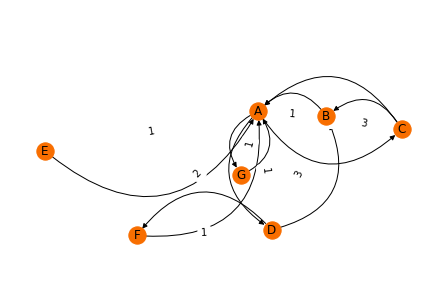

In [16]:
import networkx as nx
from matplotlib import pyplot as plt
import scipy
import pickle
import random

G = nx.DiGraph()

edges = [('G','A'), ('G','A'),('G','A'),('G','A'), ('A','G'),('B','A'),
                  ('C','A'),('A','C'),('A','D'),
                  ('E','A'),('F','A'), ('F','A'),('D','B'),
                  ('D','F')]

# G.add_edges_from(edges)


def aggregate(G, edges):
    for edge in edges:
            from_node, to_node = edge[0], edge[1]
            if G.has_edge(from_node, to_node):
                # we added this one before, just increase the weight by one
                G[from_node][to_node]['weight'] += 1
            else:
                # new edge. add with weight=1
                G.add_edge(from_node, to_node, weight=1)

aggregate(G, edges)

ppr1 = nx.pagerank(G)

labels = nx.get_edge_attributes(G,'weight')

print("Page rank value: ", ppr1)
pos = nx.spring_layout(G)
sen_rank = sorted(ppr1.items(), key=lambda x: x[1], reverse=True)
print("sorted Page rank value: ", sen_rank)
nx.draw(G, pos, with_labels = True, node_color="#f86e00", connectionstyle='arc3, rad = 0.3')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


plt.show()

## Test weighted

In [14]:
import networkx as nx
D=nx.DiGraph()
D.add_weighted_edges_from([('A','B',0.5),('A','C',0.5)])
print (nx.pagerank(D))

D['A']['C']['weight']=1
print (nx.pagerank(D))

{'A': 0.25974050510584634, 'B': 0.37012974744707666, 'C': 0.37012974744707666}
{'A': 0.25974050510584634, 'B': 0.3333333333333332, 'C': 0.40692616156082007}
